# Testing the Standard VECM Model

This notebook demonstrates how to build, estimate, and validate a Vector Error Correction Model (VECM) using the standard implementation.  
We follow the workflow:
1. Import and initialize the model.
2. Build the required matrices.
3. Estimate parameters.
4. Check model diagnostics and results.

The goal is to verify correctness of the implementation and illustrate its usage on example data.

## Model Diagnostics and Output

After estimation, we check:
- Estimated cointegration rank,
- Loading and cointegration matrices (α and β),
- Residual covariance structure,
- Information criteria (BIC).

This ensures the fitted model aligns with theoretical expectations.

In [154]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.linalg import inv as invert_matrix
from numpy.linalg import matrix_rank
from statsmodels.tools.sm_exceptions import HessianInversionWarning

from helpers import Helpers
from multinomial_logit_model import MultinomialLogit
from vecm_model_standard import VECMModel

warnings.simplefilter("ignore", HessianInversionWarning)
warnings.filterwarnings("ignore", category=UserWarning)

This python notebook, will test the standard vecm model, with parameter estimations from Section 3.3 of our paper.
We will start by reading in the data we gathered.

In [155]:
# This should be the path to the data_1.csv file on your local machine
PATH = "/Users/noah/Downloads/sol_spot_futures_data_kuma_sol.csv"
SKIP_ROWS = 0
N_ROWS = 50000
# The exchange names as hinted in footnote 1 of our paper
DF_NAMES = ['binance', 'bitmart', 'bybit', 'hashkey', 'htx', 'bitget', 'deribit', 'kuma', 'hyperliquid']

VECM_model_b = VECMModel()
VECM_model_a = VECMModel()
helper_methods = Helpers()

binance, bitmart, bybit, hashkey, htx, bitget, deribit, kuma, hyperliquid = helper_methods.read_csv_to_dataframe(PATH, SKIP_ROWS, N_ROWS, DF_NAMES)

Next we will construct $Y_{-1}^{(b)}$ and $Y_{-1}^{(a)}$

In [156]:
Y_b = VECM_model_b.construct_Y([binance.bids, bitmart.bids, bybit.bids, htx.bids, bitget.bids, deribit.bids, kuma.bids, hyperliquid.bids])
Y_a = VECM_model_a.construct_Y([binance.asks, bitmart.asks, bybit.asks, htx.asks, bitget.asks, deribit.asks, kuma.asks, hyperliquid.asks])

In [157]:
# Should both be of size TxK now 
Y_b.shape, Y_a.shape

((8, 49918), (8, 49918))

## Lag Selection

We start by estimating the lag of a VAR($d$) model with different lags m and then choose the optimal lag via information criteria such as HQ, SC, AIC, FPE as described in Section 3.3.2 of our paper.

The following implements HQ, SC, AIC, and FPE, which are defined as:

- Akaike Information Criterion (AIC):
  $$
  \text{AIC}(m) = \ln |\hat{\Sigma}_u(m)| + \frac{2}{T} \cdot mK^2
  $$
- Hannan–Quinn Criterion (HQ):
  $$
  \text{HQ}(m) = \ln |\hat{\Sigma}_u(m)| + \frac{2 \ln \ln T}{T} \cdot  mK^2
  $$
- Schwarz Criterion (SC or BIC):
  $$
  \text{SC}(m) = \ln |\hat{\Sigma}_u(d)| + \frac{\ln T}{T} \cdot mK^2
  $$
- Final Prediction Error (FPE):
  $$
  \text{FPE}(m) = \left( \frac{T + \text{Km + 1}}{T - \text{Km - 1}} \right)^K \cdot |\hat{\Sigma}_u(m)|
  $$

Where:

- $T$ is the number of observations,
- $m$ is the lag order of the VAR model,
- $K$ is the number of endogenous variables in the system,
- $\hat{\Sigma}_u(m)$ is the estimated residual covariance matrix from the VAR($m$) model.

--- 

The VAR($d$) model itself, has the following form: 

$$
Y = BZ + U
$$

Where:

- $Y \coloneqq (y_1, \dots, y_T)$, where $Y \in \mathbb{R}^{K \times T}$
- $B \coloneqq (\nu, A_1, \dots, A_p)$, where $B \in \mathbb{R}^{K \times (Kd + 1)}$
- $Z_t \coloneqq \begin{bmatrix} 1 \\ y_{t-1} \\ \vdots \\ y_{t-d} \end{bmatrix}$, so $Z_t \in \mathbb{R}^{(Kd + 1) \times 1}$
- $Z \coloneqq (Z_0, \dots, Z_{T-1})$, where $Z \in \mathbb{R}^{(Kd + 1) \times T}$
- $U \coloneqq (u_1, \dots, u_T)$, where $U \in \mathbb{R}^{K \times T}$

This follows directly from a $K$-dimensional multiple time series  
$y_1, \dots, y_T$ with $y_t = (y_{1t}, \dots, y_{Kt})'$ is available and known to be generated by a stationary, stable VAR($d$) process:

$$
y_t = \nu + A_1 y_{t-1} + \cdots + A_d y_{t-d} + u_t
$$

All symbols have their usual meanings:

- $\nu = (\nu_1, \dots, \nu_K)'$ is a $(K \times 1)$ vector of intercept terms,
- $A_i$ are $(K \times K)$ coefficient matrices,
- $u_t$ is white noise with nonsingular covariance matrix $\Sigma_u$.

The coefficients $\nu$, $A_1, \dots, A_d$, and $\Sigma_u$ are assumed to be unknown.

The maximum order $M \geq m$ we choose is 50. We will compute the results of the different tests in a loop over all integer m's from 1 to M (including M).

Since $Y^{(b)}$ and $Y^{(a)}$ have to be $I(1)$ for a VECM, we check this first

In [158]:
N = min(10000, Y_b.shape[1])

for idx in range(Y_b.shape[0]):
    time_series = np.diff(Y_b[idx][:N]) # The method adf_p_value drops nan (the frist value each itself)
    try:
        p_value = VECM_model_b.adf_p_value(time_series)
        if p_value <= 0.05:
            print(f"column {idx} is staionary after differencing")
        else:
            print(f"column {idx} is not staionary after differencing")

    except Exception as excp:
        print(excp)

column 0 is staionary after differencing
column 1 is staionary after differencing
column 2 is staionary after differencing
column 3 is staionary after differencing
column 4 is staionary after differencing
column 5 is staionary after differencing
column 6 is staionary after differencing
column 7 is staionary after differencing


In [159]:
# Same for the ask side

N = min(10000, Y_a.shape[1]) # We suggest not to choose N too large, or it will run very long

for idx in range(Y_a.shape[0]):
    time_series = np.diff(Y_a[idx][:N]) # The method adf_p_value drops nan (the frist value each itself)
    try:
        p_value = VECM_model_a.adf_p_value(time_series)
        if p_value <= 0.05:
            print(f"column {idx} is staionary after differencing")
        else:
            print(f"column {idx} is not staionary after differencing")

    except Exception as excp:
        print(excp)

column 0 is staionary after differencing
column 1 is staionary after differencing
column 2 is staionary after differencing
column 3 is staionary after differencing
column 4 is staionary after differencing
column 5 is staionary after differencing
column 6 is staionary after differencing
column 7 is staionary after differencing


Since we need to pick a certain train (and test) percentage we will choose the standard train size of 70%, to avoid lookahead bias

In [160]:
Y_train_b, Y_test_b = VECM_model_b.train_test_split_Y(Y_b, 0.7)
Y_train_a, Y_test_a = VECM_model_a.train_test_split_Y(Y_a, 0.7)

In [161]:
M = 50
# Store results in dicts
res_HQ, res_SC, res_AIC, res_FPE = {}, {}, {}, {}

for m in range(1,M+1):
    Y = Y_train_b[:,m:N]
    VECM_model_b.build_var_matrix(Y_train_b[:,:N], m)
    Z = VECM_model_b.get_var_matrix()

    K, T = Y_train_b[:,:N].shape[0], Y_train_b[:,:N].shape[1] - m

    Z_Z_T_inv = invert_matrix(Z @ Z.T)

    I_T = np.eye(T)
    # This is very memory intensive: (1 / T) * Y @ (I_T - Z.T @ Z_Z_T_inv @ Z) @ Y.T, since Z.T @ Z_Z_T_inv @ Z is almost of shape (T, T)
    # Therefore we use (Y - Y @ Z.T @ Z_Z_T_inv @ Z) (Y - Y @ Z.T @ Z_Z_T_inv @ Z).T wich can also be seen in 
    # Equation (3.2.18) Luetkepohl (2005), *New Introduction to Multiple Time Series Analysis*.
    sigma_u_tilde = (1 / T) * (Y - Y @ Z.T @ Z_Z_T_inv @ Z) @ (Y - Y @ Z.T @ Z_Z_T_inv @ Z).T

    # (3.2.19) from Luetkepohl (2005), *New Introduction to Multiple Time Series Analysis*, mentiones
    # an unbiased estimator of the covariance matrix, given by, the user can decide if he want to use this or not.
    sigma_u_hat = T / (T - K*m - 1) * sigma_u_tilde

    # Calls compute_HQC wich computes the Hannan-Quinn information criterion 
    HQ_m = VECM_model_b.compute_HQC(sigma_u_hat, m, T)

    # Calls compute_SC wich computes the Schwarz Criterion 
    SC_m = VECM_model_b.compute_SC(sigma_u_hat, m, T)

    # Calls compute_AIC wich computes the Akaike Information Criterion
    AIC_m = VECM_model_b.compute_AIC(sigma_u_hat, m, T)

    # Calls compute_FPE wich computes the Final Prediction Error
    FPE_m = VECM_model_b.compute_FPE(sigma_u_hat, m, T)

    # keep track of the results
    res_HQ[m] = HQ_m
    res_SC[m] = SC_m
    res_AIC[m] = AIC_m
    res_FPE[m] = FPE_m

Now we need to compute the argmin of each dict to get the minimum key (lag)

In [162]:
optimal_p = helper_methods.argmin_dict_value(res_HQ)
print(f"Optimal lag order according to HQ is d = {optimal_p} for the bid side series")

optimal_p = helper_methods.argmin_dict_value(res_SC)
print(f"Optimal lag order according to SC is d = {optimal_p} for the bid side series")

optimal_p = helper_methods.argmin_dict_value(res_AIC)
print(f"Optimal lag order according to AIC is d = {optimal_p} for the bid side series")

optimal_p = helper_methods.argmin_dict_value(res_FPE)
print(f"Optimal lag order according to FPE is d = {optimal_p} for the bid side series")

Optimal lag order according to HQ is d = 1 for the bid side series
Optimal lag order according to SC is d = 1 for the bid side series
Optimal lag order according to AIC is d = 3 for the bid side series
Optimal lag order according to FPE is d = 3 for the bid side series


We now set the lag manually via a setter method in VECMModel, therefore it is safer to set the lag > true lag

In [163]:
VECM_model_b.lag = 10

Lets do the same for the ask side process

In [164]:
M = 50
# Store results in dicts
res_HQ, res_SC, res_AIC, res_FPE = {}, {}, {}, {}

for m in range(1,M+1):
    Y = Y_train_a[:,m:N]
    VECM_model_a.build_var_matrix(Y_train_a[:,:N], m)
    Z = VECM_model_a.get_var_matrix()

    K, T = Y_train_b[:,:N].shape[0], Y_train_b[:,:N].shape[1] - m

    Z_Z_T_inv = invert_matrix(Z @ Z.T)

    I_T = np.eye(T)
    # This is very memory intensive: (1 / T) * Y @ (I_T - Z.T @ Z_Z_T_inv @ Z) @ Y.T, since Z.T @ Z_Z_T_inv @ Z is almost of shape (T, T)
    # Therefore we use (Y - Y @ Z.T @ Z_Z_T_inv @ Z) (Y - Y @ Z.T @ Z_Z_T_inv @ Z).T wich can also be seen in 
    # Equation (3.2.18) Luetkepohl (2005), *New Introduction to Multiple Time Series Analysis*.
    sigma_u_tilde = (1 / T) * (Y - Y @ Z.T @ Z_Z_T_inv @ Z) @ (Y - Y @ Z.T @ Z_Z_T_inv @ Z).T

    # (3.2.19) from Luetkepohl (2005), *New Introduction to Multiple Time Series Analysis*, mentiones
    # an unbiased estimator of the covariance matrix, given by, the user can decide if he want to use this or not.
    sigma_u_hat = T / (T - K*m - 1) * sigma_u_tilde

    # Calls compute_HQC wich computes the Hannan-Quinn information criterion 
    HQ_m = VECM_model_a.compute_HQC(sigma_u_hat, m, T)

    # Calls compute_SC wich computes the Schwarz Criterion 
    SC_m = VECM_model_a.compute_SC(sigma_u_hat, m, T)

    # Calls compute_AIC wich computes the Akaike Information Criterion
    AIC_m = VECM_model_a.compute_AIC(sigma_u_hat, m, T)

    # Calls compute_FPE wich computes the Final Prediction Error
    FPE_m = VECM_model_a.compute_FPE(sigma_u_hat, m, T)

    # keep track of the results
    res_HQ[m] = HQ_m
    res_SC[m] = SC_m
    res_AIC[m] = AIC_m
    res_FPE[m] = FPE_m

In [165]:
optimal_p = helper_methods.argmin_dict_value(res_HQ)
print(f"Optimal lag order according to HQ is d = {optimal_p} for the ask side series")

optimal_p = helper_methods.argmin_dict_value(res_SC)
print(f"Optimal lag order according to SC is d = {optimal_p} for the ask side series")

optimal_p = helper_methods.argmin_dict_value(res_AIC)
print(f"Optimal lag order according to AIC is d = {optimal_p} for the ask side series")

optimal_p = helper_methods.argmin_dict_value(res_FPE)
print(f"Optimal lag order according to FPE is d = {optimal_p} for the ask side series")

Optimal lag order according to HQ is d = 1 for the ask side series
Optimal lag order according to SC is d = 1 for the ask side series
Optimal lag order according to AIC is d = 1 for the ask side series
Optimal lag order according to FPE is d = 1 for the ask side series


In [166]:
VECM_model_a.lag = 10

We now build the matrix representation of a VECM from equation 3.2 in our paper.

$$
\Delta Y^{(b)} = \Pi^{(b)} Y_{-1}^{(b)} + \Gamma^{(b)} \Delta X^{(b)} + U^{(b)}
$$

where

$$
\Delta Y^{(b)} := \bigl[ \Delta y^{(b)}_{1}, \ldots, \Delta y^{(b)}_{T} \bigr],
$$

$$
Y_{-1}^{(b)} := \bigl[ y^{(b)}_{0}, \ldots, y^{(b)}_{T-1} \bigr],
$$

$$
\Gamma^{(b)} := \bigl[ \Gamma^{(b)}_{1}, \ldots, \Gamma^{(b)}_{p} \bigr],
$$

$$
\Delta X^{(b)} := \bigl[ \Delta X^{(b)}_{0}, \ldots, \Delta X^{(b)}_{T-1} \bigr],
\quad \text{with} \quad
\Delta X^{(b)}_{t-1} :=
\begin{bmatrix}
\Delta y^{(b)}_{t-1} \\
\vdots \\
\Delta y^{(b)}_{t-p}
\end{bmatrix},
$$

$$
U^{(b)} := \bigl[ u^{(b)}_{1}, \ldots, u^{(b)}_{T} \bigr].
$$

The estimation of the model parameters based on the maximum likelihood (ML) 
approach for the matrix representation in will be discussed shortly,

### Building VECM Matrices

We now construct the differenced and lagged data matrices that form the basis of the VECM.  
This step prepares:
- $\Delta Y$: differenced dependent variables,
- $Y_{-1}$: lagged levels,
- $\Delta X$: lagged differenced regressors.

These are essential inputs for rank and lag selection.

In [167]:
VECM_model_b.build_vecm_matrices(Y_train_b)
VECM_model_a.build_vecm_matrices(Y_train_a)

In case we want to print the matrices, we can retrieve them via the following code

In [168]:
delta_Y_b, delta_X_b, Y_minus_1_b = VECM_model_b.get_vecm_matrices()
delta_Y_a, delta_X_a, Y_minus_1_a = VECM_model_a.get_vecm_matrices()

In [169]:
Y_train_b.shape

(8, 34942)

In [170]:
delta_Y_b.shape, delta_X_b.shape, Y_minus_1_b.shape

((8, 34931), (80, 34931), (8, 34931))

In [171]:
delta_Y_a.shape, delta_X_a.shape, Y_minus_1_a.shape

((8, 34931), (80, 34931), (8, 34931))

## Rank Selection

Before estimating the (other) parameters of our VECM we need to determine the rank of our VECM, we therefore use the two likeliehood ratio-based tests.

This refers to Section 3.3.3 of our paper. We first need to build the residual convariance matrices, in order to get the eigenvectors.

Johansen proposed two likelihood ratio (LR) test statistics based on the eigenvalues 
$\lambda_1^{(b)} > \lambda_2^{(b)} > \cdots > \lambda_K^{(b)}$ derived from the residuals of the VECM estimation.  

The **trace statistic**, which tests the joint null hypothesis that the number of cointegrating vectors is at most $r_0$, is given by:

$$
\lambda_{\text{trace}}(r_0) = -T \sum_{i=r_0+1}^{K} \ln(1 - \lambda_i^{(b)}),
$$

while the **maximum eigenvalue statistic**, which tests $H_0 : \operatorname{rk}(\Pi^{(b)}) = r_0$ against 
$H_1 : \operatorname{rk}(\Pi^{(b)}) = r_0 + 1$, is defined as:

$$
\lambda_{\max}(r_0) = -T \ln(1 - \lambda_{r_0+1}^{(b)}).
$$

---

The cointegration rank is then determined by testing increasing values of $r_0$ sequentially, 
starting from 0, using either the **maximum eigenvalue statistic**, or **trace statistic**. The testing stops once the null 
hypothesis cannot be rejected. The corresponding $r$ is then chosen as the cointegration rank.

In the following 'johansen matrix' refers to:

$S_{11}^{(b)\,-1/2} S_{10}^{(b)} S_{00}^{(b)\,-1} S_{01}^{(b)} S_{11}^{(b)\,-1/2}$.

In [172]:
VECM_model_b.build_residual_covariances()
VECM_model_a.build_residual_covariances()

In [173]:
S_tilde_b = VECM_model_b.get_johansen_matrix()
S_tilde_a = VECM_model_a.get_johansen_matrix()

In [174]:
eigvals_sorted_b, _ = VECM_model_b.sort_eigenvectors(S_tilde_b)
eigvals_sorted_a, _ = VECM_model_a.sort_eigenvectors(S_tilde_a)

In [175]:
# Critic values
trace_crit_vals_5pct = np.asarray([197.37, 159.53, 127.52, 98.88, 73.94, 53.48, 35.65])
maxeig_crit_vals_5pct = np.asarray([62.42, 50.60, 39.37, 30.04, 22.00, 15.67, 9.24])

In [176]:
# estimate r via...
# Trace test statistics
K = eigvals_sorted_b.shape[0]

trace_stats_b = np.asarray([
    VECM_model_b.compute_likelihood_ratio_test_statistic(r0, eigvals_sorted_b)
    for r0 in range(K-1)
])

# Max-eigenvalue test statistics
maxeig_stats_b = np.asarray([
    VECM_model_b.compute_max_eigenvalue_ratio_test_statistic(r0, eigvals_sorted_b)
    for r0 in range(K-1)
])

r_trace = VECM_model_b.determine_cointegration_rank(trace_stats_b, trace_crit_vals_5pct)
r_maxeig = VECM_model_b.determine_cointegration_rank(maxeig_stats_b, maxeig_crit_vals_5pct)

print(f"=> r trace bid side: {r_trace}")
print(f"=> r rank bid side: {r_trace}")

=> r trace bid side: 7
=> r rank bid side: 7


In [177]:
# estimate r via...
# Trace test statistics
K = eigvals_sorted_b.shape[0]

trace_stats_a = np.asarray([
    VECM_model_a.compute_likelihood_ratio_test_statistic(r0, eigvals_sorted_a)
    for r0 in range(K-1)
])

# Max-eigenvalue test statistics
maxeig_stats_a = np.asarray([
    VECM_model_a.compute_max_eigenvalue_ratio_test_statistic(r0, eigvals_sorted_a)
    for r0 in range(K-1)
])

r_trace = VECM_model_a.determine_cointegration_rank(trace_stats_a, trace_crit_vals_5pct)
r_maxeig = VECM_model_a.determine_cointegration_rank(maxeig_stats_a, maxeig_crit_vals_5pct)

print(f"=> r trace ask side: {r_trace}")
print(f"=> r rank ask side: {r_trace}")

=> r trace ask side: 7
=> r rank ask side: 7


As already hinted in 3.3.3, the rank for the bid and ask side series is the same.

In [178]:
# Finally set the rank
VECM_model_b.rank = 7 # K - 1
VECM_model_a.rank = 7 # K - 1

We now estimate the (other) parameters of our VECM as described in Section 3.3.1 in our Paper, describing the ML estimation.

The parameters are again defined in the following...

$$
\beta^{(b)} = \widetilde{\beta}^{(b)} := [\nu_1^{(b)}, \ldots, \nu_r^{(b)}]^\top (S_{11}^{(b)})^{-1/2},
$$

$$
\alpha^{(b)} = \widetilde{\alpha}^{(b)} := \Delta Y^{(b)} M^{(b)} Y_{-p}^{(b)} \bigl( (\widetilde{\beta}^{(b)})^\top Y_{-1}^{(b)} M^{(b)} Y_{-1}^{(b)} \widetilde{\beta}^{(b)} \bigr)^{-1}
= S_{01}^{(b)} \widetilde{\beta}^{(b)} \bigl( (\widetilde{\beta}^{(b)})^\top S_{11}^{(b)} \widetilde{\beta}^{(b)} \bigr)^{-1},
$$

$$
\Gamma^{(b)} = \widetilde{\Gamma}^{(b)} := \bigl( \Delta Y^{(b)} - \widetilde{\alpha}^{(b)} (\widetilde{\beta}^{(b)})^\top Y_{-1}^{(b)} \bigr) \Delta X^{(b)} \bigl( \Delta X^{(b)} (\Delta X^{(b)})^\top \bigr)^{-1},
$$

$$
\Sigma_u^{(b)} = \widetilde{\Sigma}_u^{(b)} := 
\bigl( \Delta Y^{(b)} - \widetilde{\alpha}^{(b)} (\widetilde{\beta}^{(b)})^\top Y_{-1}^{(b)} - \widetilde{\Gamma}^{(b)} \Delta X^{(b)} \bigr)
\bigl( \Delta Y^{(b)} - \widetilde{\alpha}^{(b)} (\widetilde{\beta}^{(b)})^\top Y_{-1}^{(b)} - \widetilde{\Gamma}^{(b)} \Delta X^{(b)} \bigr)^\top / T.
$$

The matrix of lag-$p$ values of $y_t^{(b)}$ is

$$
Y_{-p}^{(b)} := [y_{p-1}^{(b)}, \ldots, y_{T-1}^{(b)}].
$$

---

The projection and residual matrices used in the estimation are defined by (here $I_T$ denotes the $T \times T$ identity matrix):

$$
M^{(b)} := I_T - (\Delta X^{(b)})^\top \bigl( \Delta X^{(b)} (\Delta X^{(b)})^\top \bigr)^{-1} \Delta X^{(b)},
$$

$$
R_0^{(b)} := \Delta Y^{(b)} M^{(b)},
$$

$$
R_1^{(b)} := Y_{-1}^{(b)} M^{(b)},
$$

$$
S_{ij}^{(b)} := R_i^{(b)} (R_j^{(b)})^\top / T, \quad i,j \in \{0,1\}.
$$

---

$\mathbf{v}_1, \ldots, \mathbf{v}_K$ are the orthonormal eigenvectors corresponding to the ordered eigenvalues
$\lambda_1 \geq \cdots \geq \lambda_K$ of the matrix

$$
S_{11}^{(b) -1/2} S_{10}^{(b)} S_{00}^{(b) -1} S_{01}^{(b)} S_{11}^{(b) -1/2}.
$$

In [179]:
alpha_b, beta_b, Gammas_b, Sigma_u_b = VECM_model_b.vecm_variable_estimation()
alpha_a, beta_a, Gammas_a, Sigma_u_a = VECM_model_a.vecm_variable_estimation()

$$
\Xi^{(b)} \;=\; \beta_{\perp}^{(b)} 
\Bigg[ \, (\alpha_{\perp}^{(b)})^{\top} 
\Bigg( I_K - \sum_{i=1}^{p} \Gamma_i^{(b)} \Bigg) 
\beta_{\perp}^{(b)} \,\Bigg]^{-1} 
(\alpha_{\perp}^{(b)})^{\top}.
$$

The matrix $\Xi^{(b)} \in \mathbb{R}^{K \times (K - r)}$ captures the contribution of the $K - r$ common stochastic trends,  
i.e., the nonstationary components driving the long-run dynamics of the system.  

If 
$$
(\alpha_{\perp}^{(b)})^{\top} 
\Bigg( I_K - \sum_{i=1}^{p} \Gamma_i^{(b)} \Bigg) 
\beta_{\perp}^{(b)}
$$ 
is invertible, then $\operatorname{rk}(\Xi^{(b)}) = K - r$.  

In the special case where there are $r = K - 1$ cointegration relationships,  
$\Xi^{(b)}$ has rank equal to $1$. This property will be exploited in the section on  
common trend components.

In [180]:
#

We now turn to the definition of the efficient latent price, making use of Eq. 4.36 and Eq. 4.42 from the paper.

Following Eq. 4.33, we define the $j$-th row vector containing the unscaled latent efficient price of the $j$-th variable, for the whole bid-side price vector, as

$$
\Lambda^{(b)} := \big( Y_{-1}^{(b)} \Xi^{(b)} \big)_j, 
\qquad j \in \{1, \ldots, K\}.
$$

Since this identification is only unique up to a nonsingular rotation, we need to scale $\Lambda^{(b)}$ in order to compare it to the observed price series of a particular exchange $\{y^{(b)}_{t,j}\}_{t=1}^T$ within $\{y^{(b)}_t\}_{t=1}^T$.  
The resulting scaled projection for the $j$-th exchange can then be interpreted as its latent efficient price.

We therefore define the unscaled common trend component associated with the $j$-th exchange (corresponding to the $j$-th entry of $y^{(b)}_t$) at time $t \in \{1, \ldots, T\}$ as

$$
\tilde{y}^{(b)}_{t,j} := \Lambda^{(b)}_t.
$$

---

To match the observed series $\{y^{(b)}_{t,j}\}_{t=1}^T$, we rescale $\{\tilde{y}^{(b)}_{t,j}\}_{t=1}^T$ by choosing a scalar $\phi^{(b)}_j \in \mathbb{R}$ that minimizes the squared $\ell_2$-distance. This yields the least squares problem

$$
\hat{\phi}^{(b)}_j := \arg\min_{\phi \in \mathbb{R}} \sum_{t=1}^T \left| y^{(b)}_{t,j} - \phi \tilde{y}^{(b)}_{t,j} \right|^2.
$$

The rescaled efficient price series is then

$$
\hat{y}^{(b)}_{t,j} := \hat{\phi}^{(b)}_j \, \tilde{y}^{(b)}_{t,j}, \quad t \in \{1, \ldots, T\}.
$$

---

To express this more compactly, define the vectors

$$
\mathbf{y}^{(b)}_j =
\begin{bmatrix}
y^{(b)}_{1j} \\
y^{(b)}_{2j} \\
\vdots \\
y^{(b)}_{Tj}
\end{bmatrix},
\qquad
\tilde{\mathbf{y}}^{(b)}_j =
\begin{bmatrix}
\tilde{y}^{(b)}_{1j} \\
\tilde{y}^{(b)}_{2j} \\
\vdots \\
\tilde{y}^{(b)}_{Tj}
\end{bmatrix},
$$

where both $\mathbf{y}^{(b)}_j$ and $\tilde{\mathbf{y}}^{(b)}_j$ lie in $\mathbb{R}^{T \times 1}$.

---

The least squares problem then becomes

$$
\hat{\phi}^{(b)}_j := \arg\min_{\phi \in \mathbb{R}} \big\| \mathbf{y}^{(b)}_j - \phi \tilde{\mathbf{y}}^{(b)}_j \big\|^2,
$$

which has the closed-form solution

$$
\hat{\phi}^{(b)}_j
= \left( (\tilde{\mathbf{y}}^{(b)}_j)^\top \tilde{\mathbf{y}}^{(b)}_j \right)^{-1}
  (\tilde{\mathbf{y}}^{(b)}_j)^\top \mathbf{y}^{(b)}_j
= \frac{ (\tilde{\mathbf{y}}^{(b)}_j)^\top \mathbf{y}^{(b)}_j }
       { \| \tilde{\mathbf{y}}^{(b)}_j \|^2 }.
$$

In [181]:
matrix_rank(alpha_b @ beta_b.T), matrix_rank(alpha_a @ beta_a.T)

(np.int64(7), np.int64(7))

In [182]:
# Compute basis vectors for the orthogonal complements of alpha and beta for the bid and ask side respectively
alpha_perp_b = VECM_model_b.compute_null_space_basis(alpha_b.T)
beta_perp_b = VECM_model_b.compute_null_space_basis(beta_b.T)

alpha_perp_a = VECM_model_a.compute_null_space_basis(alpha_a.T)
beta_perp_a = VECM_model_a.compute_null_space_basis(beta_a.T)

In [183]:
Xi_b = VECM_model_b.compute_granger_representation_matrix_XI(alpha_perp_b, beta_perp_b, Gammas_b)
Xi_a = VECM_model_a.compute_granger_representation_matrix_XI(alpha_perp_a, beta_perp_a, Gammas_a)

In [201]:
# The variable we want to use to collect its fair price
j = 6 # < K

Remember we need only use the train data for fitting any params

In [202]:
Lambda_b = (Xi_b @ Y_train_b)[j]
Lambda_a = (Xi_b @ Y_train_b)[j]

In [203]:
y_b = Y_train_b[j].T
y_breve_b = Lambda_b

y_a = Y_train_a[j].T
y_breve_a = Lambda_a

In [204]:
phi_b = VECM_model_b.estimate_phi(y_b, y_breve_b)
phi_a = VECM_model_a.estimate_phi(y_a, y_breve_a)

In [205]:
efficient_price_b = phi_b * (Xi_b @ Y_test_b)[j]
efficient_price_a = phi_a * (Xi_b @ Y_test_a)[j]

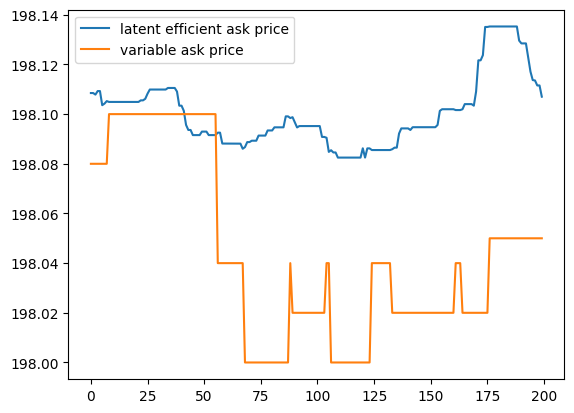

In [206]:
plt.plot(efficient_price_a[0:200], label = "latent efficient ask price")
plt.plot(Y_test_a[j][0:200], label = "variable ask price")
plt.legend()
plt.show()

We now turn to Section 4.3 of our paper, where we introduce the $P$–$T$ decomposition of $y_t^{(b)}$, 
valid for $t \in \{1, \ldots, T\}$:

$$
y_t^{(b)} = A_1^{(b)} (\beta_\perp^{(b)})^\top y_t^{(b)} + A_2^{(b)} (\alpha^{(b)})^\top y_t^{(b)}.
\qquad (4.41)
$$

The matrices $A_1^{(b)}$ and $A_2^{(b)}$ are defined as

$$
A_1^{(b)} := \alpha_\perp^{(b)} \Big( (\beta_\perp^{(b)})^\top \alpha_\perp^{(b)} \Big)^{-1} 
\in \mathbb{R}^{K \times r},
\quad
A_2^{(b)} := \beta^{(b)} \Big( (\alpha^{(b)})^\top \beta^{(b)} \Big)^{-1} 
\in \mathbb{R}^{K \times (K-r)}.
$$

Here, $\alpha^{(b)}$ and $\beta^{(b)}$ are obtained from a fitted VECM, either as described in Sections 3.3 or 3.4 of our Paper.  
According to Engle and Granger (1987), this decomposition exists if  

$$
\det \!\left( (\alpha^{(b)})^\top \beta^{(b)} \right) \neq 0,
$$  

which ensures that the block matrix $\big( \beta_\perp^{(b)}, \alpha^{(b)} \big)$ is nonsingular.  

---

The representation in (4.41) satisfies two important properties:  

1. The common factors $(\beta_\perp^{(b)})^\top y_t^{(b)}$ are not cointegrated, meaning they do not share any stationary long-run relationships.  
2. The transitory component $(\alpha^{(b)})^\top y_t^{(b)}$ does not drive the permanent component $(\beta_\perp^{(b)})^\top y_t^{(b)}$ in the long run.  

Thus, short-run movements in $(\alpha^{(b)})^\top y_t^{(b)}$ have no predictive content for the long-run dynamics, which are governed entirely by the permanent part.  

These conditions mirror those typically imposed in factor analysis, where common factors are assumed to be mutually uncorrelated and orthogonal to the idiosyncratic components.  

---

Based on this decomposition, we define the **latent efficient bid price** as the permanent component of the $P$–$T$ decomposition, i.e. the part that excludes short-run transitory shocks. For each $t \in \{1, \ldots, T\}$ and variable $j \in \{1, \ldots, K\}$, it is given by

$$
\hat{y}_{t,j}^{(b)} := \big( A_1^{(b)} (\beta_\perp^{(b)})^\top y_t^{(b)} \big)_j.
\qquad (4.42)
$$

In [207]:
np.linalg.det(alpha_b.T @ beta_b) != 0, np.linalg.det(alpha_a.T @ beta_a) != 0

(np.True_, np.True_)

In [208]:
beta_perp_b

array([[0.35351927],
       [0.35350299],
       [0.35353424],
       [0.35360711],
       [0.35356979],
       [0.35375297],
       [0.35339128],
       [0.35354937]])

In [209]:
persistent_component_b_train, transitory_component_b_train = VECM_model_b.compute_P_T_decomposition(alpha_b, beta_b, alpha_perp_b, beta_perp_b, Y_train_b)
persistent_component_a_train, transitory_component_a_train = VECM_model_a.compute_P_T_decomposition(alpha_b, beta_b, alpha_perp_a, beta_perp_a, Y_train_a)

persistent_component_b_test, transitory_component_b_test = VECM_model_b.compute_P_T_decomposition(alpha_b, beta_b, alpha_perp_b, beta_perp_b, Y_test_b)
persistent_component_a_test, transitory_component_a_test = VECM_model_a.compute_P_T_decomposition(alpha_b, beta_b, alpha_perp_a, beta_perp_a, Y_test_a)

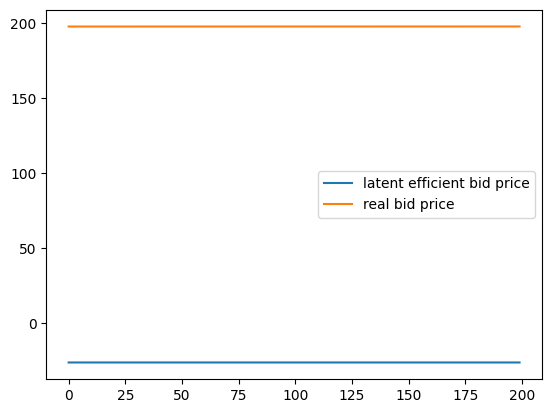

In [210]:
plt.plot((persistent_component_b_test)[j][:200], label = "latent efficient bid price")
plt.plot((Y_test_b)[j][0:200], label = "real bid price")
plt.legend()
plt.show()

### Fit the Multinomial Logit Model

As outlined in the Methodology and Framework section, we assume that the return within the cluster of lagging price processes depends on the return of the leading bid/ask price process. To formalize this dependency, we model the (signed) return in the $j$-th cluster of the lagging bid price process—conditioned on the past $\mathcal{D} \in \mathbb{N}^{+}$ lagged returns from both the lagging and leading bid (or ask) price processes—as a Multinoulli-distributed random variable:

$$
\left( R_{C_{j}^{y^{(b)}}} ;\middle|; r_{C_{j-\mathcal{D}:j-1}^{y^{(b)}}},; r_{C_{j-\mathcal{D}+1:j}^{\widehat{y}^{(b)}}} \right)
\sim \text{Multinoulli}(p_{j,-1},; p_{j,0},; p_{j,+1}),
$$

where the outcome variable is defined by the sign of the total return in the cluster:
$R_{C_{j}^{y^{(b)}}} = \operatorname{sign}(r_{C_{j}^{y^{(b)}}})$
with $\operatorname{sign}(x) = +1$ if $x>0$, $-1$ if $x<0$, and $0$ if $x=0$.

---

The conditional class probabilities are:

$$
\begin{aligned}
p_{j,+1}^{(b)} &= \mathbb{P}!\left[ R_{C_{j}^{y^{(b)}}} = +1 ;\middle|; r_{C_{j-\mathcal{D}:j-1}^{y^{(b)}}},; r_{C_{j-\mathcal{D}+1:j}^{\widehat{y}^{(b)}}} \right], \
p_{j,-1}^{(b)} &= \mathbb{P}!\left[ R_{C_{j}^{y^{(b)}}} = -1 ;\middle|; r_{C_{j-\mathcal{D}:j-1}^{y^{(b)}}},; r_{C_{j-\mathcal{D}+1:j}^{\widehat{y}^{(b)}}} \right], \
p_{j,0}^{(b)}  &= \mathbb{P}!\left[ R_{C_{j}^{y^{(b)}}} = 0  ;\middle|; r_{C_{j-\mathcal{D}:j-1}^{y^{(b)}}},; r_{C_{j-\mathcal{D}+1:j}^{\widehat{y}^{(b)}}} \right].
\end{aligned}
$$

Here, $\text{Multinoulli}(p_{j,-1}^{(b)}, p_{j,0}^{(b)}, p_{j,+1}^{(b)})$ refers to a categorical distribution over three outcomes. It generalizes the Bernoulli distribution to more than two unordered classes, making it well-suited for modeling discrete probabilistic events when exactly one outcome is realized.

---

The linear predictors for the three classes at index $\mathcal{D} \leq j < T$ are:

$$
\begin{aligned}
\theta_{j,+1}^{(b)} &= \alpha_{+1}^{(b)} + \sum_{s=0}^{\mathcal{D}-1} \psi_{s,+1}^{(b)} r_{C_{j-s}^{\widehat{y}^{(b)}}}
	•	\sum_{s=1}^{\mathcal{D}} \gamma_{s,+1}^{(b)} r_{C_{j-s}^{y^{(b)}}} + \sum_{z=1}^{\mathcal{L}} \phi_{z,+1}^{(b)} \big(\widehat{y}{z}^{(b)} - y{z}^{(b)}\big), \
\theta_{j,-1}^{(b)} &= \alpha_{-1}^{(b)} + \sum_{s=0}^{\mathcal{D}-1} \psi_{s,-1}^{(b)} r_{C_{j-s}^{\widehat{y}^{(b)}}}
	•	\sum_{s=1}^{\mathcal{D}} \gamma_{s,-1}^{(b)} r_{C_{j-s}^{y^{(b)}}} + \sum_{z=1}^{\mathcal{L}} \phi_{z,-1}^{(b)} \big(\widehat{y}{z}^{(b)} - y{z}^{(b)}\big), \
\theta_{j,0}^{(b)}  &= \alpha_{0}^{(b)} + \sum_{s=0}^{\mathcal{D}-1} \psi_{s,0}^{(b)} r_{C_{j-s}^{\widehat{y}^{(b)}}}
	•	\sum_{s=1}^{\mathcal{D}} \gamma_{s,0}^{(b)} r_{C_{j-s}^{y^{(b)}}} + \sum_{z=1}^{\mathcal{L}} \phi_{z,0}^{(b)} \big(\widehat{y}{z}^{(b)} - y{z}^{(b)}\big).
\end{aligned}
$$

The final term in each predictor, $(\widehat{y}{j}^{(b)} - y{j}^{(b)})$, is not part of the model in Poutre (2024). We include it to capture predictive information in the difference between the latent efficient price and the observed price, as motivated by Section Testing the Common Trend Component.

---

Using the multinomial logit form, the class probabilities become:

$$
\begin{aligned}
p_{j,+1}^{(b)} &= \frac{e^{\theta_{j,+1}^{(b)}}}{1 + e^{\theta_{j,-1}^{(b)}} + e^{\theta_{j,+1}^{(b)}}}, \
p_{j,-1}^{(b)} &= \frac{e^{\theta_{j,-1}^{(b)}}}{1 + e^{\theta_{j,-1}^{(b)}} + e^{\theta_{j,+1}^{(b)}}}, \
p_{j,0}^{(b)}  &= \frac{1}{1 + e^{\theta_{j,-1}^{(b)}} + e^{\theta_{j,+1}^{(b)}}}.
\end{aligned}
$$

---

The parameters to be estimated, denoted by $\Theta^{(b)}$, can be obtained by maximum likelihood. Assuming the bid price series ${ y^{(b)}{j,t} }{t=1}^{T}$ consists of $\mathcal{N}$ return clusters, the likelihood is:

$$
\mathcal{L}(\Theta^{(b)}) ;=; \prod_{j=\mathcal{D}}^{\mathcal{N}}
\left(p_{j,+1}^{(b)}\right)^{\mathbf{1}({ R_{C_j^{y^{(b)}}} = +1 })}
\left(p_{j,-1}^{(b)}\right)^{\mathbf{1}({ R_{C_j^{y^{(b)}}} = -1 })}
\left(p_{j,0}^{(b)}\right)^{\mathbf{1}({ R_{C_j^{y^{(b)}}} = 0 })}.
$$

We estimate $\Theta^{(b)}$ using the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm, called by MNLogit under the hood.


In [211]:
# Only test bid series here
multionmial_logit_b = MultinomialLogit()

# Define leader and lagger series
# x is leading y
# Define train data
x_series_train_b = pd.Series((persistent_component_b_train)[j])
y_series_train_b = pd.Series(Y_train_b[j])

# Define test data
x_series_test_b = pd.Series(persistent_component_b_test[j])
y_series_test_b = pd.Series(Y_test_b[j])

In [212]:
# Check if the max correlation occurs at a negative lag => x leads y
multionmial_logit_b.estimate_lead_lag_correlation(x_series_train_b, y_series_train_b, max_lag = 50), multionmial_logit_b.estimate_lead_lag_correlation(x_series_test_b, y_series_test_b, max_lag = 50)

(0, 0)

In [213]:
# Compute the data frame with cluster ids
cluster_df_train_b = multionmial_logit_b.compute_static_cluster_returns(x_series_train_b, y_series_train_b)
cluster_df_test_b = multionmial_logit_b.compute_static_cluster_returns(x_series_test_b, y_series_test_b)

In [214]:
# Generate the training data and fit the model with the train data we already have
# Lookback length for clusters
D = 20

X_train, y_train = multionmial_logit_b.generate_model_data(cluster_df_train_b, D)
X_test, y_test = multionmial_logit_b.generate_model_data(cluster_df_test_b, D)

model = multionmial_logit_b.fit(X_train, y_train)

In [215]:
# Check the performance

TP = FP = TN = FN = 0
# threshold kappa
kappa = 0.7

for i in range(len(X_test)):
    prediction = model.predict(X_test[i])[0]
    true_value = np.sign(y_test[i])

    # down prediction
   
    # up prediction
    if np.max(prediction) == prediction[2] and np.max(prediction) >= kappa:
        if true_value == +1:
            TP += 1
        else:
            FP += 1

    elif np.max(prediction) == prediction[0] and np.max(prediction) >= kappa:
        if true_value == -1:
            TN += 1
        else:
            FN += 1

    else:
        pass

In [ ]:
TP, FP, TN, FN

(0, 0)